In [20]:
import os
import re
import string
import fasttext 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Softmax
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
from nltk.stem.snowball import PorterStemmer

In [2]:
fasttext.FastText.eprint = lambda x: None

## Data preprocessing
---

We will use the Cornell Movie Review Dataset as offered by the `nltk` package: 

In [3]:
nltk.download('movie_reviews', quiet=True)

True

Each review corresponds to a `file_id` which we are going to utilize to create two lists of strings; one for reviews and one for the sentiment label:

In [4]:
x = [' '.join(movie_reviews.words(file_id)) for file_id in movie_reviews.fileids()]
y = [movie_reviews.categories(file_id)[0] for file_id in movie_reviews.fileids()]

We split our data to 70% training, 15% development, and 15% testing sets:

In [5]:
y = [0 if label == 'neg' else 1 for label in y]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

(len(x_train), len(x_val), len(x_test))

(1400, 300, 300)

The final length of our training, development and test subset equal to 1400, 300 and 300 reviews respectively.

## Feature selection
---

We tokenize each review to word level, while removing stopwords and punctuation symbols:

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner', 'lemmatizer'])
nlp.add_pipe('sentencizer') 

x_train_tokenized = []
for idx in range(len(x_train)):
    doc = nlp(x_train[idx])
    tokens = []
    for sent in doc.sents:
        for tok in sent:
            if '\n' in tok.text or '\t' in tok.text or '--' in tok.text or\
            '*' in tok.text or tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
                continue
            if tok.text.strip():  
                tokens.append(tok.text.replace('"', "'").strip())
    x_train_tokenized.append(tokens)

x_val_tokenized = []
for idx in range(len(x_val)):
    doc = nlp(x_val[idx])
    tokens = []
    for sent in doc.sents:
        for tok in sent:
            if '\n' in tok.text or '\t' in tok.text or '--' in tok.text or\
            '*' in tok.text or tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
                continue
            if tok.text.strip():
                tokens.append(tok.text.replace('"', "'").strip())
    x_val_tokenized.append(tokens)

x_test_tokenized = []
for idx in range(len(x_test)):
    doc = nlp(x_test[idx])
    tokens = []
    for sent in doc.sents:
        for tok in sent:
            if '\n' in tok.text or '\t' in tok.text or '--' in tok.text or\
            '*' in tok.text or tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
                continue
            if tok.text.strip():
                tokens.append(tok.text.replace('"', "'").strip())
    x_test_tokenized.append(tokens)

In [7]:
print('Mean review word length before feature selection: {:.2f}'.format(np.mean([len(x) for x in x_train])))
print('Mean review word length after feature selection: {:.2f}'.format(np.mean([len(x) for x in x_train_tokenized])))

Mean review word length before feature selection: 3912.91
Mean review word length after feature selection: 330.44


We continue with transforming our tokenized reviews to sequences of index and padding short-enough reviews to a fixed sequence length:

In [8]:
MAX_WORDS = 100000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1024

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS, oov_token='UNK')

tokenizer.fit_on_texts([" ".join(x) for x in x_train_tokenized])

train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_train_tokenized])
train_data = tf.keras.utils.pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

val_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_val_tokenized])
val_data = tf.keras.utils.pad_sequences(val_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_test_tokenized])
test_data = tf.keras.utils.pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [9]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 33964 unique tokens.


The unique tokens found on the training dataset are about 34k.

Moving on, we create an embedding matrix by utilizing `fasttext` pre-trained embeddings on the english language:

In [10]:
fasttext_model = fasttext.load_model('cc.en.300.bin')
embedding_matrix = np.zeros(shape=((MAX_WORDS + 2), 300))

for key, value in word_index.items():
    if value <= MAX_WORDS:
        embedding_matrix[value] = fasttext_model.get_word_vector(word=key)

del fasttext_model

## Bi-directional RNN with self-attention MLP
---

First things first, we one-hot-encode our problems' labels:

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

For monitoring the development performance we will use the following callback metrics function:

In [12]:
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

We will also use the following function for calculating per class metrics:

In [13]:
def calculate_class_AUC_score(y_true, y_pred, labels):
    """
    Calculates AUC scores for the given class label.
    """
    precision = [0, _, 1]
    recall = [1, _, 0]
    cr = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    precision[1] = cr[labels]['precision']
    recall[1] = cr[labels]['recall']
    auc_score = auc(recall, precision)
    return auc_score

We will create a custom class for creating a slef-attention layer:

In [14]:
class SelfAttention(tf.keras.layers.Layer):

    def __init__(self, mlp_layers, units, return_attention=False, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.mlp_layers = mlp_layers
        self.mlp_units = units
        self.return_attention = return_attention
        self.attention_mlp = self.build_mlp()
  
    def build_mlp(self):
        mlp = tf.keras.Sequential()
        for i in range(self.mlp_layers):
            mlp.add(tf.keras.layers.Dense(self.mlp_units, activation='elu'))
        mlp.add(tf.keras.layers.Dense(1))
        return mlp
  
    def call(self, x, mask=None):
        a = self.attention_mlp(x)
        a = tf.squeeze(a, axis=2)
        if mask is not None:
            mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
            a -= 100000.0 * (1.0 - mask)
            a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))
            weighted_input = x * a
            result = tf.keras.backend.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, a]
        return result

Our model consists of the embedding layer, a bi-directional RNN, the self-attention with 3 hidden layers and a fully connected layer with 1024 nodes. We utilize dropout layers in between for reguralization purposes. Last, but not least, we follow the eraly stopping approach, forcing the training to terminate if the validation loss stops improving for 10 consecutive epochs:

In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

GRU_SIZE = 300

model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Embedding(
        MAX_WORDS+2, 
        EMBEDDING_DIM, 
        weights=[embedding_matrix], 
        input_length=MAX_SEQUENCE_LENGTH, 
        mask_zero=True,
        trainable=False
    )
)
model.add(tf.keras.layers.Dropout(0.25))

model.add(
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            GRU_SIZE,
            return_sequences=True,
            recurrent_dropout = 0.25
        )
    )
)
model.add(tf.keras.layers.Dropout(0.25))

model.add(SelfAttention(mlp_layers=3, units=256))

model.add(tf.keras.layers.Dense(1024, activation='relu' ))
model.add(tf.keras.layers.Dropout(0.35))

model.add(tf.keras.layers.Dense(2, activation='softmax'))

print(model.summary())

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["categorical_accuracy"]
)

history = model.fit(
    train_data,
    y_train,
    validation_data=(val_data, y_val),
    batch_size=256,
    epochs=50,
    shuffle=True,
    callbacks=[
        Metrics(valid_data=(val_data, y_val)),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 300)         30000600  
                                                                 
 dropout (Dropout)           (None, 1024, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1024, 600)        1083600   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1024, 600)         0         
                                                                 
 self_attention (SelfAttenti  (None, 600)              285697    
 on)                                                             
                                                                 
 dense_4 (Dense)             (None, 1024)              6

/opt/anaconda3/envs/practical-ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [==============================] - 187s 31s/step - loss: 0.6849 - categorical_accuracy: 0.5757 - val_loss: 0.7006 - val_categorical_accuracy: 0.4967 - val_f1: 0.3296 - val_recall: 0.4967 - val_precision: 0.2467
Epoch 2/50
10/10 [==============================] - 30s 3s/steps: 0.6736 - categorical_acc
 — val_f1: 0.536590 — val_precision: 0.751923 — val_recall: 0.603333
6/6 [==============================] - 181s 31s/step - loss: 0.6736 - categorical_accuracy: 0.5650 - val_loss: 0.6565 - val_categorical_accuracy: 0.6033 - val_f1: 0.5366 - val_recall: 0.6033 - val_precision: 0.7519
Epoch 3/50
10/10 [==============================] - 30s 3s/steps: 0.6114 - categorical_acc
 — val_f1: 0.647308 — val_precision: 0.702019 — val_recall: 0.663333
6/6 [==============================] - 179s 31s/step - loss: 0.6114 - categorical_accuracy: 0.6729 - val_loss: 0.6281 - val_categorical_accuracy: 0.6633 - val_f1: 0.6473 - val_recall: 0.6633 - val_precision: 0.7020
Epoch 4/50
10/10 [=================

We visualize the model's train and validation loss:

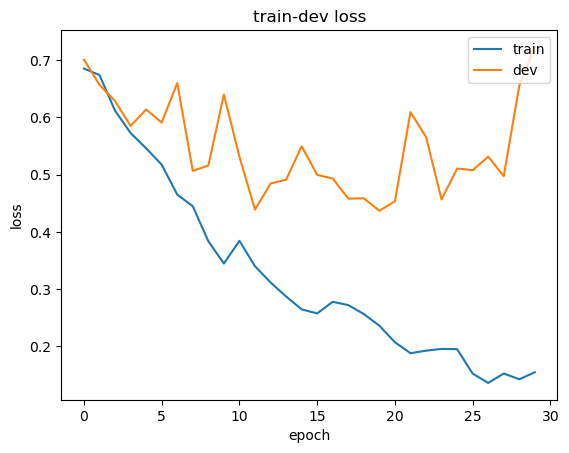

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train-dev loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

We notice how during the last epochs of training the two curves significantly deviate indicating ealy steps of overfitting.

In [17]:
# train: precision, recall, f1
predictions_train = np.argmax(model.predict(train_data, verbose=0), -1)
y_train_ = np.argmax(y_train, -1)
print('Training set')
print('===========')
print(classification_report(y_train_, predictions_train))

# train: auc
auc_class0_test = calculate_class_AUC_score(y_train_, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_train_, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

Training set
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       698
           1       0.93      0.96      0.95       702

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400

class 0 AUC: 0.947
class 1 AUC: 0.949

macro-average AUC: 0.948


In [18]:
# val: precision, recall, f1
predictions_dev = np.argmax(model.predict(val_data, verbose=0), -1)
y_val_ = np.argmax(y_val, -1)
print('Validation set')
print('===========')
print(classification_report(y_val_, predictions_dev))

# val: auc
auc_class0_test = calculate_class_AUC_score(y_val_, predictions_dev, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_val_, predictions_dev, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

Validation set
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       149
           1       0.88      0.79      0.83       151

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300

class 0 AUC: 0.845
class 1 AUC: 0.832

macro-average AUC: 0.838


Testing set
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       153
           1       0.89      0.81      0.85       147

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

class 0 AUC: 0.867
class 1 AUC: 0.849

macro-average AUC: 0.858


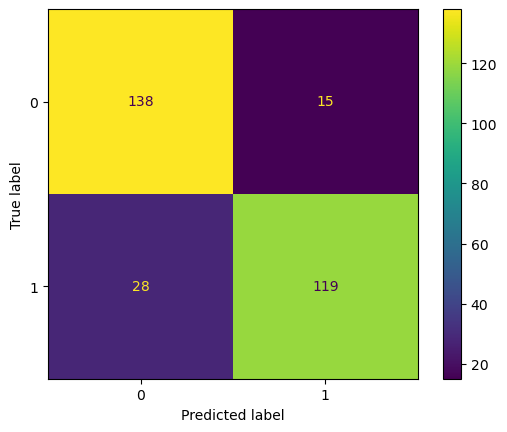

In [19]:
# test: precision, recall, f1
predictions_test = np.argmax(model.predict(test_data, verbose=0), -1)
y_test_ = np.argmax(y_test, -1)
print('Testing set')
print('===========')
print(classification_report(y_test_, predictions_test))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test_, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test_, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
cf_matrix = confusion_matrix(y_test_, predictions_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0', '1'])
cm_display.plot()
plt.show()